In [1]:
from sklearn.metrics import mean_absolute_error as MSE
from cmcrameri import cm
from tqdm import tqdm
from common import *
from models import *

2021-12-17 15:44:00.541917: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-17 15:44:00.541993: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Reading in the data

In [2]:
df = pd.read_csv("../data/input_data/MAIN_DATASET.csv")
price = df['NO2_price'].values.reshape(-1,1)

In [3]:
scaler = MinMaxScaler()
price = scaler.fit_transform(price)

In [4]:
lookbehind = 7
input_width = lookbehind*24
horizon = 24
no_hours = input_width + horizon

price_dataset = []

for i in range(0, len(price) - input_width, horizon):
    price_dataset.append(price[i:i+no_hours])

price_dataset = np.array(price_dataset)

dataset = price_dataset
n,m,k = dataset.shape
print(n,m,k)

2145 192 1


In [5]:
train = int(0.7*n)
valid = int(0.9*n)
X_train = dataset[:train, :input_width]
X_valid = dataset[train:valid, :input_width]
X_test = dataset[valid:, :input_width]

Y = np.empty((n, input_width, horizon))
for step_ahead in range(1, horizon + 1):
    Y[:,:, step_ahead - 1] = dataset[:,step_ahead:step_ahead + input_width, 0]

Y_train = Y[:train]
Y_valid = Y[train:valid]
Y_test = Y[valid:]

The idea behind this grid search is to first study which cells performs the best for our current dataset, with a univariate model

# Common parameters for Grid Search

In [6]:
epochs = 10
no_neurons = np.array([16,32,64,128])
mse_list_small = np.zeros((3, len(no_neurons)))
best_mse_small = np.inf*np.ones(3)

In [7]:
for n, neurons in enumerate(no_neurons):
    print(f"Iteration {n}")
    rnn = keras.models.Sequential([
        keras.layers.SimpleRNN(neurons, return_sequences=True, input_shape=[None, 1]),
        keras.layers.Dense(horizon)
    ])

    lstm = keras.models.Sequential([
        keras.layers.LSTM(neurons, return_sequences=True, input_shape=[None, 1]),
        keras.layers.Dense(horizon)
    ])

    gru = keras.models.Sequential([
        keras.layers.GRU(neurons, return_sequences=True, input_shape=[None, 1]),
        keras.layers.Dense(horizon)
    ])

    rnn.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
    lstm.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
    gru.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])

    rnn.fit(X_train, Y_train, epochs=epochs, validation_data=(X_valid, Y_valid), verbose=False)
    lstm.fit(X_train, Y_train, epochs=epochs, validation_data=(X_valid, Y_valid), verbose=False)
    gru.fit(X_train, Y_train, epochs=epochs, validation_data=(X_valid, Y_valid), verbose=False)

    Y_pred_rnn = rnn.predict(X_test)
    Y_pred_lstm = lstm.predict(X_test)
    Y_pred_gru = gru.predict(X_test)

    mse_rnn = MSE(Y_test[:,-1], Y_pred_rnn[:,-1])
    mse_lstm = MSE(Y_test[:,-1], Y_pred_lstm[:,-1])
    mse_gru = MSE(Y_test[:,-1], Y_pred_gru[:,-1])

    if mse_rnn < best_mse_small[0]:
        print(f"Found new best SimpleRNN mse {mse_rnn} with {neurons} neurons")
        best_mse_small[0] = mse_rnn
        fname = f"../data/models/small_rnn.h5"
        keras.models.save_model(rnn, fname)

    if mse_lstm < best_mse_small[1]:
        print(f"Found new best LSTM mse {mse_lstm} with {neurons} neurons")
        best_mse_small[1] = mse_lstm
        fname = f"../data/models/small_lstm.h5"
        keras.models.save_model(lstm, fname)

    if mse_gru < best_mse_small[2]:
        print(f"Found new best GRU mse {mse_gru} with {neurons} neurons")
        best_mse_small[2] = mse_gru
        fname = f"../data/models/small_gru.h5"
        keras.models.save_model(gru, fname)

    mse_list_small[0,n] = mse_rnn
    mse_list_small[1,n] = mse_lstm
    mse_list_small[2,n] = mse_gru



Iteration 0


2021-12-17 15:44:03.496972: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2021-12-17 15:44:03.497381: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-17 15:44:03.497470: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2021-12-17 15:44:03.497516: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2021-12-17 15:44:03.497597: W tensorflow/stream_executor/platform/default/dso_loader.cc:6

Found new best SimpleRNN mse 0.04248968234560002 with 16 neurons
Found new best LSTM mse 0.031484144450458294 with 16 neurons
Found new best GRU mse 0.02898325399344877 with 16 neurons
Iteration 1
Found new best SimpleRNN mse 0.03771272045393253 with 32 neurons
Found new best LSTM mse 0.030661262145870286 with 32 neurons
Iteration 2
Found new best SimpleRNN mse 0.030936439593489795 with 64 neurons
Found new best LSTM mse 0.02872706295119525 with 64 neurons
Found new best GRU mse 0.028418306872478885 with 64 neurons
Iteration 3
Found new best SimpleRNN mse 0.02803054347113047 with 128 neurons


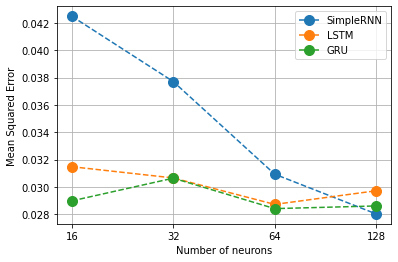

In [8]:
plt.figure()
plt.plot(mse_list_small[0], '.--', markersize=20, label="SimpleRNN")
plt.plot(mse_list_small[1], '.--', markersize=20, label="LSTM")
plt.plot(mse_list_small[2], '.--', markersize=20, label="GRU")
plt.xticks(ticks = np.arange(4), labels=no_neurons)
plt.xlabel(f"Number of neurons")
plt.ylabel(f"Mean Squared Error")
plt.grid()
plt.legend()
plt.savefig(f"../figures/small_architecture_grid_search.pdf")

# Perform the same gridsearch, but for large architecture

In [9]:
no_neurons = np.array([16,32,64,128])
mse_list = np.zeros((3, len(no_neurons), len(no_neurons)))
best_mse = np.inf*np.ones(3)

In [10]:
for n, neurons_first in enumerate(no_neurons):
    for m, neurons_second in enumerate(no_neurons):
        print(f"Iteration {n}{m}")
        rnn = keras.models.Sequential([
            keras.layers.SimpleRNN(neurons_first, return_sequences=True, input_shape=[None, 1]),
            keras.layers.SimpleRNN(neurons_second, return_sequences=True),
            keras.layers.Dense(horizon)
        ])

        lstm = keras.models.Sequential([
            keras.layers.LSTM(neurons_first, return_sequences=True, input_shape=[None, 1]),
            keras.layers.LSTM(neurons_second, return_sequences=True),
            keras.layers.Dense(horizon)
        ])

        gru = keras.models.Sequential([
            keras.layers.GRU(neurons_first, return_sequences=True, input_shape=[None, 1]),
            keras.layers.GRU(neurons_second, return_sequences=True),
            keras.layers.Dense(horizon)
        ])

        rnn.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
        lstm.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
        gru.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])

        rnn.fit(X_train, Y_train, epochs=epochs, validation_data=(X_valid, Y_valid), verbose=False)
        lstm.fit(X_train, Y_train, epochs=epochs, validation_data=(X_valid, Y_valid), verbose=False)
        gru.fit(X_train, Y_train, epochs=epochs, validation_data=(X_valid, Y_valid), verbose=False)

        Y_pred_rnn = rnn.predict(X_test)
        Y_pred_lstm = lstm.predict(X_test)
        Y_pred_gru = gru.predict(X_test)

        mse_rnn = MSE(Y_test[:,-1], Y_pred_rnn[:,-1])
        mse_lstm = MSE(Y_test[:,-1], Y_pred_lstm[:,-1])
        mse_gru = MSE(Y_test[:,-1], Y_pred_gru[:,-1])

        if mse_rnn < best_mse[0]:
            print(f"Found new best SimpleRNN mse {mse_rnn} with {neurons_first} and {neurons_second} neurons")
            best_mse[0] = mse_rnn
            fname = f"../data/models/large_rnn.h5"
            keras.models.save_model(rnn, fname)

        if mse_lstm < best_mse[1]:
            print(f"Found new best LSTM mse {mse_lstm} with {neurons_first} and {neurons_second} neurons")
            best_mse[1] = mse_lstm
            fname = f"../data/models/large_lstm.h5"
            keras.models.save_model(lstm, fname)

        if mse_gru < best_mse[2]:
            print(f"Found new best GRU mse {mse_gru} with {neurons_first} and {neurons_second} neurons")
            best_mse[2] = mse_gru
            fname = f"../data/models/large_gru.h5"
            keras.models.save_model(gru, fname)

        mse_list[0,n,m] = mse_rnn
        mse_list[1,n,m] = mse_lstm
        mse_list[2,n,m] = mse_gru

Iteration 00
Found new best SimpleRNN mse 0.04080267572060975 with 16 and 16 neurons
Found new best LSTM mse 0.03257583433613521 with 16 and 16 neurons
Found new best GRU mse 0.028640661011801627 with 16 and 16 neurons
Iteration 01
Found new best LSTM mse 0.029782209323992174 with 16 and 32 neurons
Iteration 02
Iteration 03
Found new best SimpleRNN mse 0.029057223749047012 with 16 and 128 neurons
Found new best LSTM mse 0.029316018758260856 with 16 and 128 neurons
Found new best GRU mse 0.028461607039777608 with 16 and 128 neurons
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 20
Iteration 21
Found new best GRU mse 0.027992010554322808 with 64 and 32 neurons
Iteration 22
Iteration 23
Found new best LSTM mse 0.0290088658719015 with 64 and 128 neurons
Iteration 30
Iteration 31
Iteration 32
Iteration 33


In [11]:
print(mse_list)
print(best_mse)

[[[0.04080268 0.05009565 0.04106109 0.02905722]
  [0.04563613 0.04173129 0.03404656 0.03483869]
  [0.04346305 0.04219087 0.03616917 0.03036424]
  [0.04208429 0.03407757 0.03541273 0.03519897]]

 [[0.03257583 0.02978221 0.03036022 0.02931602]
  [0.03334163 0.03064569 0.02962194 0.0299152 ]
  [0.0343795  0.03095987 0.02984983 0.02900887]
  [0.0405945  0.03219617 0.03063241 0.0294435 ]]

 [[0.02864066 0.02907141 0.02909657 0.02846161]
  [0.02949001 0.02892587 0.02893928 0.02863291]
  [0.03155077 0.02799201 0.02911176 0.02811938]
  [0.03285592 0.02907824 0.0280799  0.02826831]]]
[0.02905722 0.02900887 0.02799201]


From these results, the best models are
* SimpleRNN 128 and 128 neurons @ 0.06939392 MSE
* LSTM 32 and 128 neurons @ 0.08641151
* GRU 32 and 128 neurons @ 0.08066217